In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-11 05:54:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-11 05:54:18 (69.4 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [2]:
!pip install tf-nightly

In [3]:
import tensorflow as tf

2023-07-11 05:54:48.097106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:8894] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-11 05:54:48.097183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-11 05:54:48.097238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:

print(tf.__version__)

2.14.0-dev20230710


In [5]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Use TensorFlow datasets to Download Data

In [6]:
train_path = '/kaggle/input/food11-image-dataset/training'
validation_path ='/kaggle/input/food11-image-dataset/validation'

In [7]:
batch_size = 32
img_height = 224
img_width = 224
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Exploring the Food101 data from TensorFlow Datasets

* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels looks like (one hot encoded or label encoded)
* Do the labels match up the class names

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  validation_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.


In [9]:
class_names = train_data.class_names
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

### Plot an image from TensorFlow Datasets

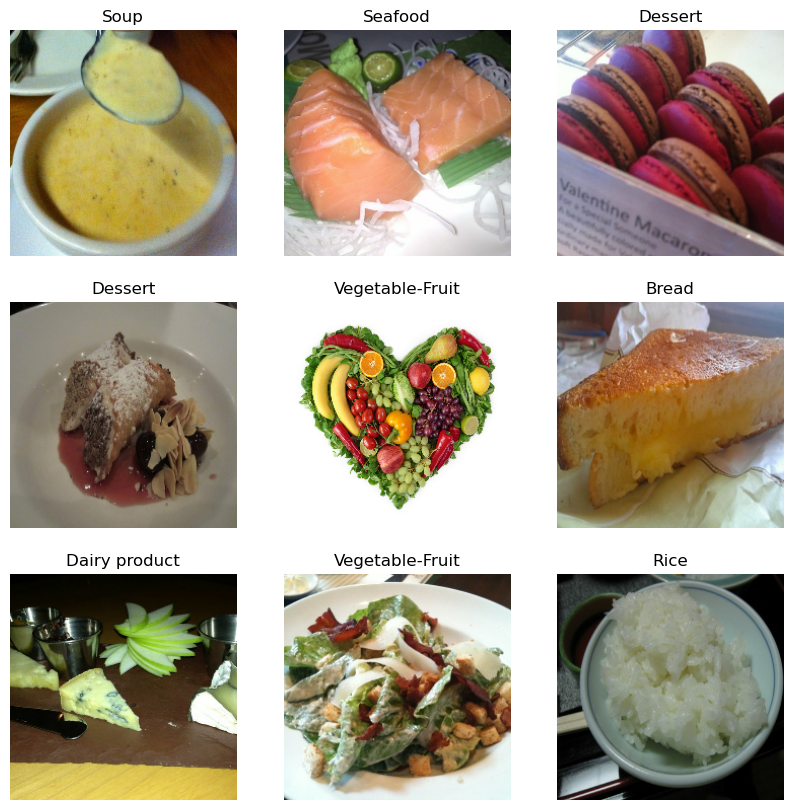

In [10]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create preprocessing functions for our data



In [11]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      moniter='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [12]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Build feature extraction model

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Rescaling for models that doesn't have rescaling built-in
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(11)(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
for layer in model.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_layer float32 <Policy "float32">
efficientnetb0 float32 <Policy "mixed_float16">
global_average_pooling2d float32 <Policy "mixed_float16">
dense float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">


In [15]:
for layer in model.layers[1].layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
rescaling_1 float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">
block1a_se_squeeze float32 <Policy "mixed_float16">
block1a_se_reshape float32 <Policy "mixed_float16">
block1a_se_reduce float32 <Policy "mixed_float16">
block1a_se_expand float32 <Policy "mixed_float16">
block1a_se_excite float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Poli

## Fit the feature extraction model

In [16]:
history_101_food_classes_feature_extraction = model.fit(train_data,
                                                        epochs=3,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback('training_logs',
                                                                                               'efficientnetb0_101_classes_all_data_fx'),
                                                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fx/20230711-055621
Epoch 1/3
309/309 [==============================] - 52s 123ms/step - loss: 0.7176 - accuracy: 0.7916 - val_loss: 0.4623 - val_accuracy: 0.8652
Epoch 2/3
309/309 [==============================] - 31s 98ms/step - loss: 0.3764 - accuracy: 0.8826 - val_loss: 0.3646 - val_accuracy: 0.9004
Epoch 3/3
309/309 [==============================] - 31s 97ms/step - loss: 0.3085 - accuracy: 0.9058 - val_loss: 0.3186 - val_accuracy: 0.8965


In [17]:
# Evaluating the model
model.evaluate(test_data)

108/108 [==============================] - 16s 143ms/step - loss: 0.3752 - accuracy: 0.8793


[0.3751676380634308, 0.8793002963066101]

In [18]:
# Clone the model to futher use it to fine tune
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
 softmax_float32 (Activatio  (None, 11)                0         
 n)                                                              
                                                             

In [19]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [20]:
cloned_model.load_weights(checkpoint_path)

In [21]:
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [22]:
# Saving the model to a file
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [23]:
for layer in cloned_model.layers[1].layers:
  layer.trainable = True

In [24]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [26]:
cloned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [27]:
history_101_food_classes_all_data_fine_tune = cloned_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvement

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230711-060116
Epoch 1/100
309/309 [==============================] - 130s 265ms/step - loss: 0.3006 - accuracy: 0.9008 - val_loss: 0.3096 - val_accuracy: 0.9004 - lr: 1.0000e-04
Epoch 2/100
309/309 [==============================] - 46s 147ms/step - loss: 0.1112 - accuracy: 0.9657 - val_loss: 0.3400 - val_accuracy: 0.8926 - lr: 1.0000e-04
Epoch 3/100
309/309 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9875
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
309/309 [==============================] - 46s 148ms/step - loss: 0.0429 - accuracy: 0.9875 - val_loss: 0.3424 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 4/100
309/309 [==============================] - 81s 260ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.2839 - val_accuracy: 0.9102 - lr: 2.0000e-05
Epoch 5/100
309/309 [==============================] - 80s 257ms/step - loss:

In [28]:
cloned_model.save("/kaggle/working/")

In [29]:
cloned_model.evaluate(test_data)

108/108 [==============================] - 13s 113ms/step - loss: 0.3850 - accuracy: 0.9120


[0.38495153188705444, 0.911953330039978]